# WorldCover product access

This notebook aims to demonstrate how [ESA WorldCover 2020](https://worldcover2020.esa.int/data/docs/WorldCover_PUM_V1.1.pdf) products can be searched and downloaded trough the Terrascope STAC API.

A STAC collection referencing all products is available trough the Terrascope STAC Catalog.

The WorldCover LCC data around the city of Mol, Belgium will be searched, download, visualized and analysed in this notebook.

In this case, the `pystac-client`, `geopandas` and `rasterio` libraries are used to access the data, while `numpy` and `matplotlib` are used for the analysis and the visualisation of the data.

More information on how to use `pystac-client` is available in the [following documentation](https://pystac-client.readthedocs.io/en/stable/).


## Connecting to the Terrascope STAC catalog and search through products

In [15]:
from pystac_client import Client

# Log in to the terrascope STAC API
TERRASCOPE_STAC_API = 'https://services.terrascope.be/stac/'
COLLECTION_ID = 'urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1'
BBOX = [5.046776, 51.151453, 5.181290, 51.241861]

client = Client.open(TERRASCOPE_STAC_API)

# Because the collection is only fixed on the 2020 year, there is no purpose in fixing a temporal criteria.
# The bounding box contains the city of Mol, Belgium
search_results = client.search(
    max_items=10,
    collections=[COLLECTION_ID],
    bbox=BBOX
)

# Search results fetched and represented as dictionnary
results = search_results.get_all_items()
results.to_dict()

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'stac_version': '1.0.0',
   'id': 'urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N51E003',
   'properties': {'datetime': '2020-12-31T23:59:59Z',
    'title': 'ESA_WorldCover_10m_2020_v100_N51E003',
    'created': '2022-10-26T13:02:05Z',
    'updated': '2022-10-25T13:37:26Z',
    'start_datetime': '2020-01-01T00:00:00Z',
    'end_datetime': '2020-12-31T23:59:59Z'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[3, 54], [3, 51], [6, 51], [6, 54], [3, 54]]]},
   'links': [{'rel': 'self',
     'href': 'https://services.terrascope.be/stac/collections/urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1/items/urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1:ESA_WorldCover_10m_2020_v100_N51E003',
     'type': 'application/geo+json'},
    {'rel': 'parent',
     'href': 'https://services.terrascope.be/stac/collections/urn:eop:VITO:ESA_WorldCover_10m_2020_AWS_V1',
     'type': 'application/json'},
    {'rel

In [2]:
# We are interested into downloading the first item of our search query.
interest_item = results.items[0]

# Each STAC item can contains assets, usually downloadable contents such as Rasters.

# List the available assets for the selection item
interest_item.assets

{'ESA_WORLDCOVER_10M_MAP': <Asset href=s3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N51E003_Map.tif>}

In [3]:
# There is only one asset available, containing a href to download our product's raster.
item_asset = interest_item.assets['ESA_WORLDCOVER_10M_MAP']
item_asset.to_dict()

{'href': 's3://esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N51E003_Map.tif',
 'type': 'image/tiff',
 'title': 'ESA_WORLDCOVER_10M_MAP',
 'roles': ['data']}

## Download of the interest worldcover product

Now that we found all the necessary information to access the product raster, let's download it using `rasterio`.

In [20]:
raster_crs

CRS.from_epsg(4326)

In [21]:
raster_transform

Affine(8.333333333333333e-05, 0.0, 3.0,
       0.0, -8.333333333333333e-05, 54.0)

In [22]:
# Open the image and download the data with rasterio.
import rasterio
import os

# The WorldCover products are available on a free AWS S3 bucket. 
# Settings this environment variable is required so that rasterio does not try to find AWS Tokens.
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

with rasterio.open(item_asset.href, 'r') as src:
    # Create a reading window from our BBOX (the spatial resolution of the WorldCover products is 10px/m)
    transform = rasterio.transform.from_bounds(*BBOX, width=src.transform[0], height=src.transform[4])
    reading_window = rasterio.windows.from_bounds(*BBOX, transform)
    
    # Read the raster data
    raster_data = src.read(1, window=reading_window)
    
raster_data

WindowError: Bounds and transform are inconsistent

## Visualisation of the downloaded map

Let's see the WorldCover map using `matplotlib`.

A small class as well as a function are defined here to convert our raster pixel values to the corresponsing WorldCover legend's colors.

In [13]:
import enum

class LabelsColors(enum.Enum):

    # 10,0,100,0,255,Trees covered area
    # 20,255,187,34,255,Shrub covered area
    # 30,255,255,76,255,Grassland
    # 40,240,150,255,255,Cropland
    # 50,250,0,0,255,Built-up
    # 60,180,180,180,255,Bare areas
    # 70,240,240,240,255,Snow and/or ice cover
    # 80,0,100,200,255,Permament water bodies
    # 90,0,150,160,255,Herbaceous wetland
    # 95,0,207,117,255,Mangroves
    # 100,250,230,160,255,Lichens and mosses

    NO_DATA = (0, 'nodata', 'Not sure', 'No Data', np.array([0, 0, 0]))
    TREE = (10, 'tree', 'tree', 'Trees covered area',
            np.array([0, 100, 0]) / 255)
    SHRUB = (20, 'shrub', 'shrub', 'Shrub cover area',
             np.array([255, 187, 34]) / 255)
    GRASS = (30, 'grass', 'grassland', 'Grassland',
             np.array([255, 255, 76]) / 255)
    CROP = (40, 'crop', 'crops', 'Cropland', np.array([240, 150, 255]) / 255)
    BUILT = (50, 'built', 'urban/built-up',
             'Built-up', np.array([250, 0, 0]) / 255)
    BARE = (60, 'bare', 'bare', 'Bare areas', np.array([180, 180, 180]) / 255)
    SNOW_AND_ICE = (70, 'snow', 'snow and ice', 'Snow and/or ice cover',
                    np.array([240, 240, 240]) / 255)
    WATER = (80, 'water', 'water', 'Permanent water',
             np.array([0, 100, 200]) / 255)
    WETLAND = (90, 'wetland', 'wetland (herbaceous)', 'Herbaceous wetland',
               np.array([0, 150, 160]) / 255)
    MANGROVES = (95, 'mangroves', None, 'Mangroves',
                 np.array([0, 207, 117]) / 255)
    LICHENS = (100, 'lichens_mosses', 'Lichen and moss', 'Lichen and moss',
               np.array([250, 230, 160]) / 255)

    def __init__(self, val1, val2, val3, val4, val5):
        self.id = val1
        self.class_name = val2
        self.iiasa_name = val3
        self.esa_class_name = val4
        self.color = val5


def label_to_rgb(lc_pred, colors_enum=None):

    colors_enum = LabelsColors if colors_enum is None else colors_enum

    colors = {lc.id: {'name': lc.class_name,
                      'color': lc.color}
              for lc in colors_enum}

    # add missing labels from OSM and GSW
    colors[51] = colors[50]
    colors[81] = colors[80]
    colors[61] = colors[60]
    colors[91] = colors[0]
    colors[92] = colors[20]
    colors[93] = colors[95]
    colors[94] = colors[0]

    rgb_pred = np.zeros((lc_pred.shape[0],
                         lc_pred.shape[1],
                         3))

    for k, v in colors.items():
        for ch in range(3):
            im = rgb_pred[:, :, ch]
            im[lc_pred == k] = v['color'][ch]

    return rgb_pred


# Translation of WorldCover integer values to land cover type name
lc_types = {
    0: 'Not available',
    10: 'Tree cover',
    20: 'Shrubland', 
    30: 'Grassland', 
    40: 'Cropland',
    50: 'Built-up',
    60: 'Base/Sparse vegetation',
    70: 'Snow and ice',
    80: 'Permanent water bodies',
    90: 'Herbaceous wetland',
    95: 'Mangroves',
    100: 'Moss and Lichen'
}

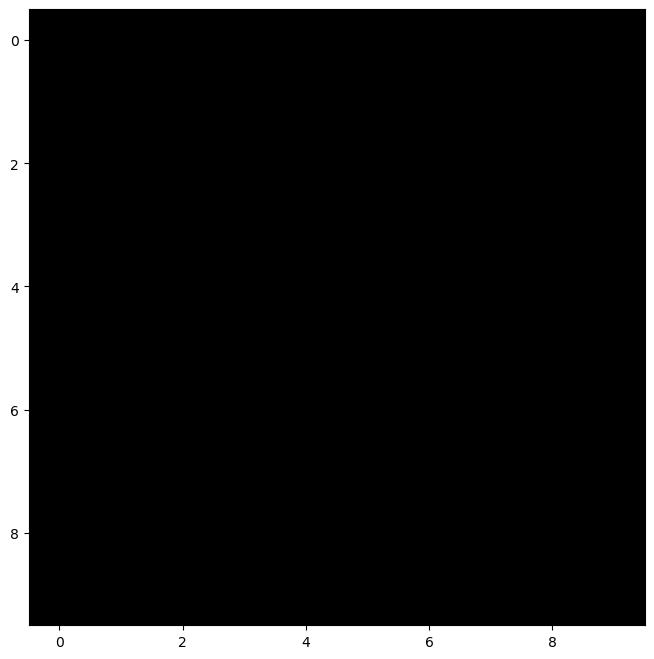

In [26]:
rgb_data = label_to_rgb(raster_data)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(rgb_data)
fig.show()

## Analysis of the downloaded land cover map

We will create a pie chart giving the proportion of land cover classes in our study region

[0] [100]


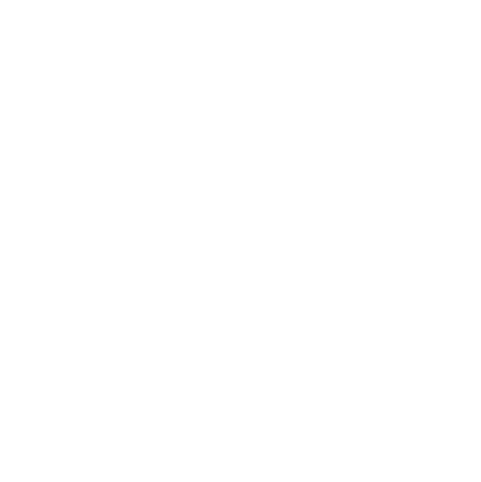

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Count the number of occurences (in pixels) for each class of the WorldCover product. 
values, occurences = np.unique(raster_data, return_counts=True)
print(values, occurences)

# Show a pie chart representing the percentage of present in the 
lc_labels = list(map(lambda val: lc_types[val], values))

fig, ax = plt.subplots(figsize=(6, 6))



ax.pie(occurences[1:],labels=lc_labels[1:], autopct='%1.1f%%',
        shadow=True, startangle=90)
fig.show()